In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import torch.nn as nn
import torchvision
from torch import optim, cuda
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader ,sampler
import matplotlib.pyplot as plt
import os
import time
import cv2
import copy
from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer
# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'


In [2]:
'''
functions in datahandler 
def process_image(image_path):
def imshow_tensor(image, ax=None, title=None):
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=2):
def display_prediction(image_path, model, topk):
def predict(image_path, model, topk=5):
def save_checkpoint(model, path,history):

make sure train_on_gpu true if training in GPU
else false;
'''

'\nfunctions in datahandler \ndef process_image(image_path):\ndef imshow_tensor(image, ax=None, title=None):\ndef train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=2):\ndef display_prediction(image_path, model, topk):\ndef predict(image_path, model, topk=5):\ndef save_checkpoint(model, path,history):\n\nmake sure train_on_gpu true if training in GPU\nelse false;\n'

In [3]:
'''
functions in getmethod files  
    def get_pretrained_model(model_name):
    def evaluate(model, test_loader, criterion, topk=[1]):
    def imshow(image):
make sure train_on_gpu true if training in GPU
else false;
'''

'\nfunctions in getmethod files  \n    def get_pretrained_model(model_name):\n    def evaluate(model, test_loader, criterion, topk=[1]):\n    def imshow(image):\nmake sure train_on_gpu true if training in GPU\nelse false;\n'

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_on_gpu=True

In [5]:
src='C:\\Users\\Harshit\\Desktop\\MTP\\training_folder'
traindir = os.path.join(src,'train')
validdir = os.path.join(src,'val')
testdir = os.path.join(src,'test')
save_file_name = 'resnet34-transfer-4.pt'
checkpoint_path = 'resnet34-transfer-4.pth'
# Change to fit hardware
batch_size = 128
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False


Train on gpu: True
1 gpus detected.


In [6]:
%run datahandler
%run get_method

1 gpus detected.
1 gpus detected.
1 gpus detected.


In [7]:
batch_size=32
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data = {
    'train':
    datasets.ImageFolder(root=os.path.join(src,'train'), transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=os.path.join(src,'val'), transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [8]:
# Iterate through the dataloader once
trainiter=iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape,labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# training

In [9]:
torch.cuda.empty_cache()

In [3]:
model=models.resnet34(pretrained=True)
# Freeze model weights
for parm in model.parameters():
    parm.requires_grad=False
model.fc = nn.Sequential(
               nn.Linear(512, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2))
model = model.to('cuda')
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,309,890 total parameters.
1,049,346 training parameters.


In [19]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Negative'), (1, 'Positive')]

In [20]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = optim.Adam(model.parameters())
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,350,594 total parameters.
65,922 training parameters.


In [25]:
save_file_name = 'resnet34-transfer-4.pt'
train_on_gpu = torch.cuda.is_available()
model, history1 = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=10,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 314.08 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.0517 	Validation Loss: 0.0222
		Training Accuracy: 98.27%	 Validation Accuracy: 99.15%
Epoch: 3	100.00% complete. 332.39 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.0425 	Validation Loss: 0.0162
		Training Accuracy: 98.52%	 Validation Accuracy: 99.45%
Epoch: 5	100.00% complete. 350.38 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.0419 	Validation Loss: 0.0132
		Training Accuracy: 98.55%	 Validation Accuracy: 99.63%
Epoch: 7	100.00% complete. 348.79 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0340 	Validation Loss: 0.0130
		Training Accuracy: 98.83%	 Validation Accuracy: 99.70%
Epoch: 9	100.00% complete. 347.55 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.0363 	Validation Loss: 0.0173
		Training Accuracy: 98.82%	 Validation Accuracy: 99.53%

Best epoch: 8 with loss: 0.01 and acc: 99.53%
3913.44 total seconds elapsed. 434.83 seconds per 

In [29]:
save_checkpoint(model, checkpoint_path,model.optimizer,history1)

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
import subprocess

def get_gpu_memory_map():
    """Get the current gpu usage.

    Returns
    -------
    usage: dict
        Keys are device ids as integers.
        Values are memory usage as integers in MB.
    """
    result = subprocess.check_output(
        [
            'nvidia-smi', '--query-gpu=memory.used',
            '--format=csv,nounits,noheader'
        ], encoding='utf-8')
    # Convert lines into a dictionary
    gpu_memory = [int(x) for x in result.strip().split('\n')]
    gpu_memory_map = dict(zip(range(len(gpu_memory)), gpu_memory))
    return gpu_memory_map


In [ ]:
a=get_gpu_memory_map()

In [ ]:
a

# loading saved model

In [9]:
model,optimizer,history=load_checkpoint(checkpoint_path)

21,350,594 total parameters.
65,922 total gradient parameters.


In [10]:
cat_df=pd.read_csv('cat_df')

# training results

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

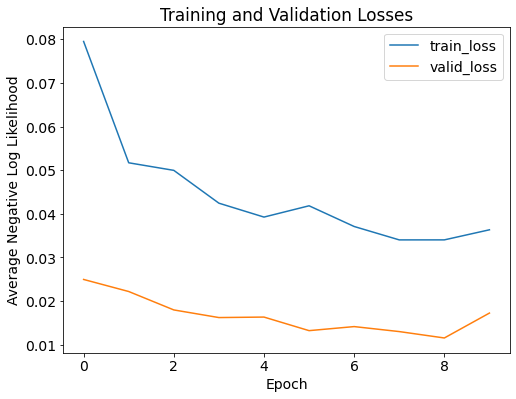

In [11]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')


<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

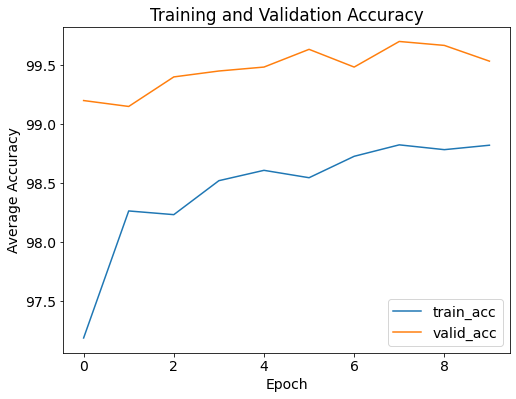

In [13]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


In [14]:
import pandas as pd


# prediction and inference

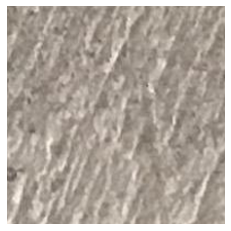

In [15]:
np.random.seed = 100
%matplotlib inline
def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = os.path.join(testdir,c)
    img_path = os.path.join(root,np.random.choice(os.listdir(root)))
    return img_path

p=random_test_image()
_ = imshow_tensor(process_image(p))


torch.Size([3, 224, 224])

Positive
[2.031299e+03 6.335220e-03]


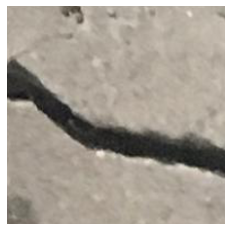

In [16]:
img, top_p, top_classes, real_class = predict(random_test_image(), model)
img.shape
ax,image=imshow_tensor(img)
print(real_class)
print(top_p)
plt.imshow(image)


In [17]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets,topk=[1])
else:
    accuracy(model(features), targets,topk=[1])


[100.0]

In [18]:
criterion = nn.CrossEntropyLoss()
results = evaluate(model, dataloaders['test'], criterion)
results.head()

,class,top1,loss
0,Negative,99.6,0.016816
1,Positive,99.7,0.011179


# test results


In [19]:
nb_classes = 2
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)


tensor([[996.,   4.],
        [  3., 997.]])


In [3]:
TP=977
TN=996
FN=3
FP=4
recall=TP/(TP+FN)
precision=TP/(TP+FP)
f1_score=2*recall*precision/(precision+recall)
acc=(TP+TN)/(TP+TN+FN+FP)

In [4]:
f1_score,acc

(0.9964303926568078, 0.9964646464646465)

Text(0.5, 6.800000000000011, 'images')

Text(-5.949999999999996, 0.5, 'Accuracy (%)')

Text(0.5, 1.0, 'Top 1 Accuracy vs Number of Training Images')

(-5.0, 105.0)

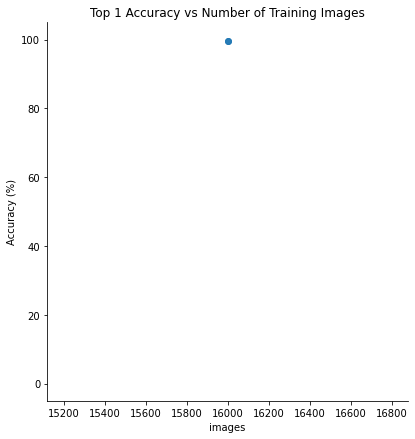

In [20]:
results = results.merge(cat_df, left_on='class', right_on='category').\
drop(columns=['category'])
# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)


In [21]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()
